In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import os

In [54]:
# These are the connections between the parts of the body. Ex: head to neck [0, 1]
POSE_PAIRS = [[0,1], # head
              [1,2],[1,5], # sholders
              [2,3],[3,4],[5,6],[6,7], # arms
              [1,14],[14,11],[14,8], # hips
              [8,9],[9,10],[11,12],[12,13]] # legs

# +1 because the iteration starts at 0.
# n_points = len(POSE_PAIRS + 1)
n_points = 15

# m -> model
m_scale = 1.0 / 255
m_size = (368, 368)
m_mean = (0, 0, 0)
m_rgb = True

CONF_THRESHOLD = 0.1


def estimate_pose(net, frame):
    blob = cv.dnn.blobFromImage(frame, m_scale, m_size, m_mean, m_rgb, crop=False)
    net.setInput(blob)
    detections = net.forward()
    return detections


def extract_points(frame, detections):
    scale_x = frame.shape[1] / detections.shape[3]  # x (width) of the probability map
    scale_y = frame.shape[0] / detections.shape[2]  # y (height) of the probability map

    points = []
    for i in range(n_points):
        """
        A probability map for a keypoint is a 2D array where each value represents the
        confidence or likelihood that the keypoint is located at that pixel position.
        Higher values indicate a stronger confidence that the keypoint is present at
        that location.

        detections.shape[0]: Number of images processed.
        detections.shape[1]: The number of detected objects.
        detections.shape[2]: (Y for probMap in this case)
        detections.shape[3]: (X for probMap in this case)
        """
        prob_map = detections[0, i, :, :]
        """
        The function cv.minMaxLoc() in OpenCV is used to find the minimum and maximum values
        in a single-channel image (such as a probability map) and their corresponding 
        locations (coordinates).
        """
        # `probability`` is the maximum value of the matrix
        min_val, probability, min_loc, point = cv.minMaxLoc(prob_map)
        # min_val, max_val, min_loc, max_loc = cv.minMaxLoc(prob_map)

        x = scale_x * point[0]
        y = scale_y * point[1]

        if probability > CONF_THRESHOLD:
            points.append((int(x), int(y)))
        else:
            points.append(None)

    return points


def drawn_keypoints(frame, points):
    copy = frame.copy()

    for i, (x, y) in enumerate(points):
        cv.circle(copy, (x, y), 5, (0, 0, 255), cv.FILLED)
        cv.putText(
            copy,
            f"{i}",
            (x, y),
            cv.FONT_HERSHEY_SIMPLEX,
            0.75,
            (255, 255, 0),
            2,
            cv.LINE_AA,
        )

    return copy


def drawn_squeleton(frame, points):
    copy = frame.copy()

    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        # If the connected points are present in the points[] list.
        if points[partA] and points[partB]:
            cv.line(copy, points[partA], points[partB], (255, 255, 0), 2)
            # Even if points[partA] happens more than once, it will just drawn a circle
            # on top of the older circle. Visually there's no difference.
            cv.circle(
                copy, points[partA], 5, (255, 0, 0), thickness=-1, lineType=cv.FILLED
            )
            cv.circle(
                copy, points[partB], 5, (255, 0, 0), thickness=-1, lineType=cv.FILLED
            )

    return copy

In [55]:
# source: https://www.dropbox.com/s/drumc6dzllfed16/pose_iter_160000.caffemodel
model_file = os.path.join(
    "..", "assets", "pose_estimation", "pose_iter_160000.caffemodel"
)
# source: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt
config_file = os.path.join(
    "..", "assets", "pose_estimation", "pose_deploy_linevec_faster_4_stages.prototxt"
)

net = cv.dnn.readNetFromCaffe(config_file, model_file)

img = cv.imread(os.path.join("..", "assets", "pose_estimation", "golf1.jpg"))

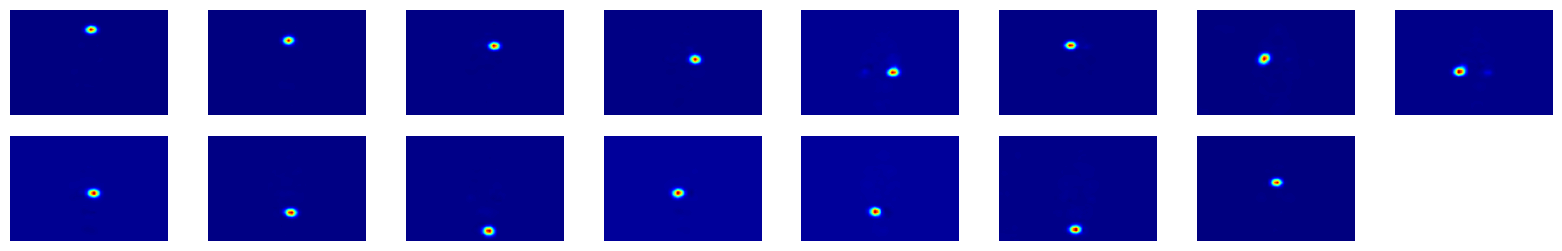

In [59]:
detections = estimate_pose(net, img)
frame_width = img.shape[1]
frame_height = img.shape[0]

# ploting the probability maps
plt.figure(figsize=[20, 3])
for i in range(n_points):
    prob_map = detections[0, i, :, :]
    # print(prob_map)
    display_map = cv.resize(prob_map, (frame_width, frame_height), interpolation=cv.INTER_LINEAR)
    plt.subplot(2, 8, i+1); plt.axis("off"); plt.imshow(display_map, cmap="jet")
    

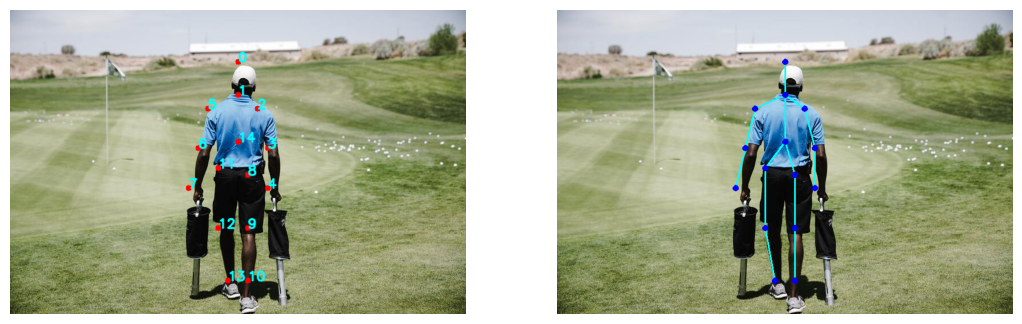

In [57]:
points = extract_points(img, detections)
keypoints_img = drawn_keypoints(img, points)
squeleton_img = drawn_squeleton(img, points)

plt.figure(figsize=[20,5])
plt.subplot(131); plt.axis("off"); plt.imshow(keypoints_img[:,:,::-1])
plt.subplot(132); plt.axis("off"); plt.imshow(squeleton_img[:,:,::-1])